# Predicting Heart Disease

The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

Assuming that we are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. The dataset has the following features:

1. `Age`: age of the patient [years]

2. `Sex`: sex of the patient [M: Male, F: Female]

3. `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

4. `RestingBP`: resting blood pressure [mm Hg]

5. `Cholesterol`: serum cholesterol [mm/dl]

6. `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

7. `RestingECG`: resting electrocardiogram results 
    * [Normal: Normal, 
    * ST: having ST-T wave abnormality (T wave inversions and/or ST  elevation or depression of > 0.05 mV), 
    * LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]

9. `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]

10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]

11. `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

12. `HeartDisease`: output class [1: heart disease, 0: Normal]

Before we jump into building a model, let's conduct exploratory data analysis on the dataset.


## EDA: Descriptive Statistics

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#read data in
heart_data = pd.read_csv("heart_disease_prediction.csv")
heart_data.shape

(918, 12)

In [3]:
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Our dataset has 918 rows(labels) and 12 columns(features), with no null values, there are 5 categorical features (`Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_slope`) and 6 numerical features (`Age`, `RestingBP`, `Cholesterol`, `FastingBS`, `MaxHR`, `HeartDisease`). Let's start by exploring the numerical features.


## EDA: Numerical columns

In [5]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We note that the average `Age` of patients is around 53 years old, with the oldest being 77 and youngest at 28.

The median for `Cholesterol` is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.

`FastingBS` and `HeartDisease` both contain binary (0 or 1) results, so although it is numerical in nature, the summary statistics are not meaningful.

Though there is no missing values, excluding the binary columns, we find that `RestingBP`and `Cholesterol` have minimum values of 0, this is unlikely and probably a representation of missing values. 

If we look up [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean) definition of our `Cholesterol`'s **serum cholesterol** values, it 

<blockquote>
"is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level."
</blockquote>

This confirms that it is impossible to have a zero value for that column. 
Let's plot some histograms and boxplot to check for outliers on numerical columns other than those identified as binary columns.


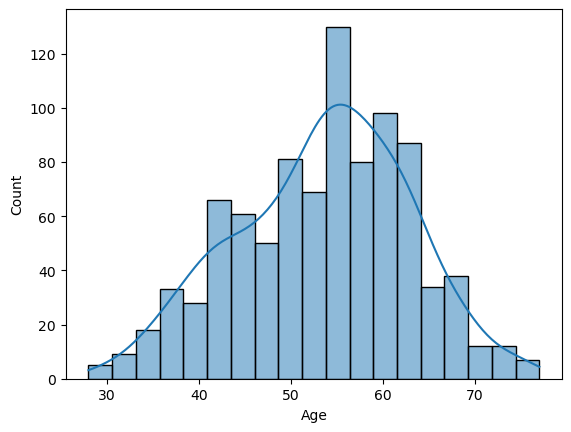

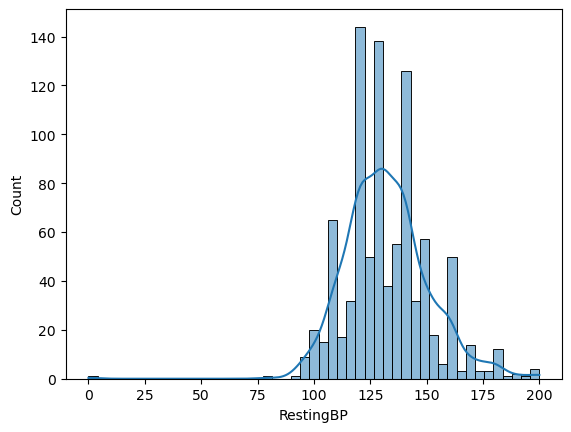

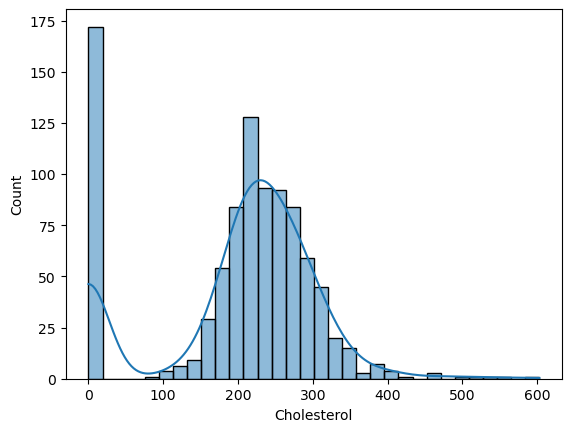

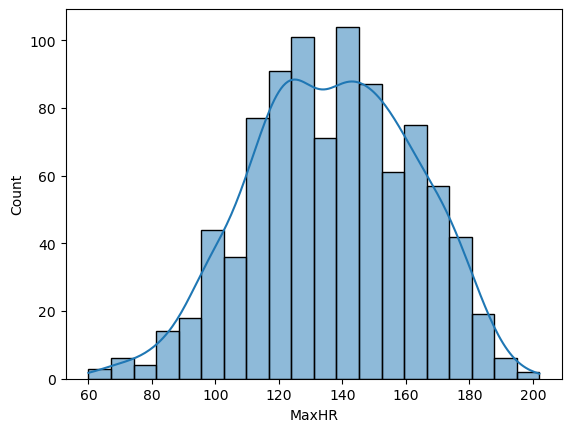

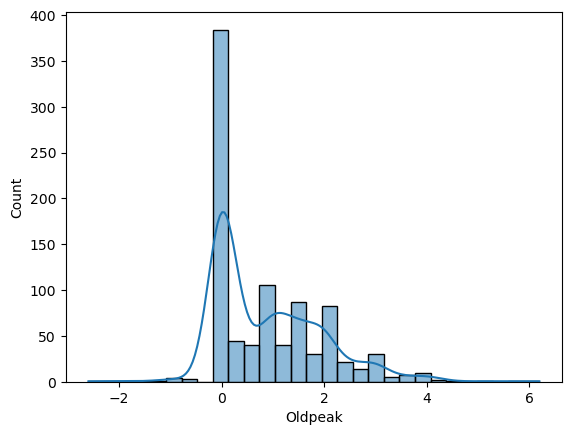

In [6]:
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',]

#plot histogram for numeric cols
for col in numeric_cols:
    plt.figure()
    sns.histplot(heart_data[col], kde=True)
    plt.xlabel(col)

c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newu

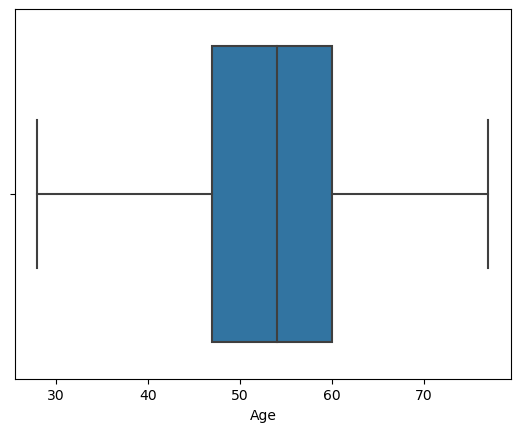

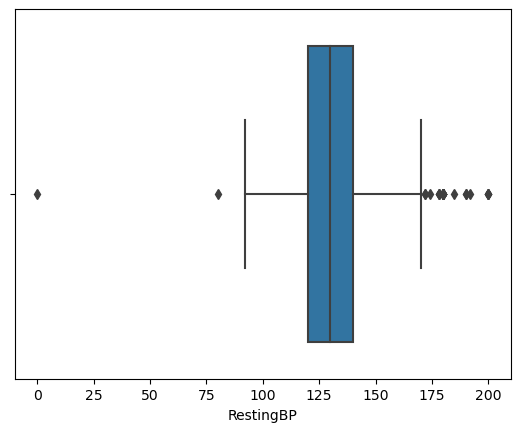

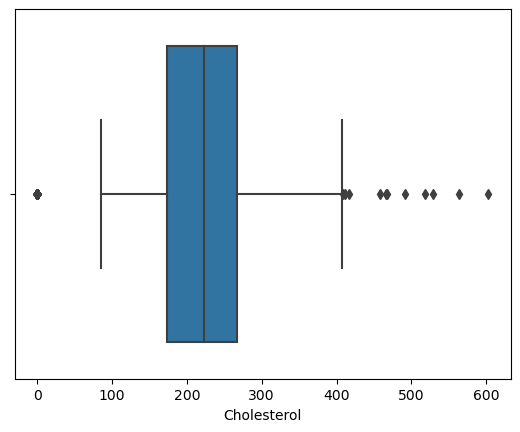

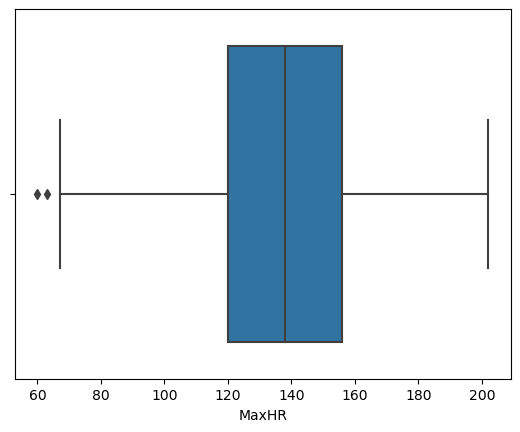

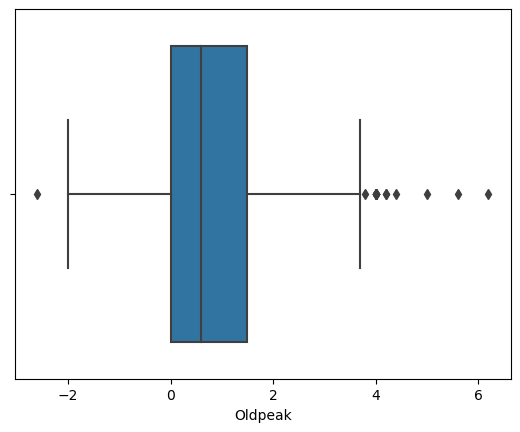

In [7]:
#plot boxplot for numeric cols
for col in numeric_cols:
    plt.figure()
    sns.boxplot(heart_data[col])
    plt.xlabel(col)

We find that for `RestingBP`, `Cholesterol`, `MaxHR`, and `Oldpeak` all have some outliers, with `RestingBP`, `Cholesterol` having some zero values that are impossible. 
We will proceed to remove the zeros followed by outlier removal.

## EDA: Incorrect zeros & Outliers

In [8]:
heart_data[heart_data["Cholesterol"] == 0].shape[0]

172

In [9]:
heart_data[heart_data["RestingBP"] == 0].shape[0]

1

- 19% (172 out of 918 data) of `Cholesterol` feature have zero values, as this is quite a substantial amount, we will replace it with a median cholesterol level rather than removing them. 

- Only 1 row of `RestingBP` has zero value, we can proceed to remove it.

In [10]:
heart_data_clean = heart_data.copy()

#replace cholesterol 0 to median
cholesterol_median = np.median(heart_data_clean["Cholesterol"])
heart_data_clean["Cholesterol"] = heart_data_clean["Cholesterol"].apply(lambda x: cholesterol_median if x==0 else x)
heart_data_clean[heart_data_clean["Cholesterol"] == 0].shape[0]

0

In [11]:
#remove 0 row from resting bp
heart_data_clean = heart_data_clean[heart_data_clean["RestingBP"] != 0]
heart_data_clean[heart_data_clean["RestingBP"] == 0].shape[0]

0

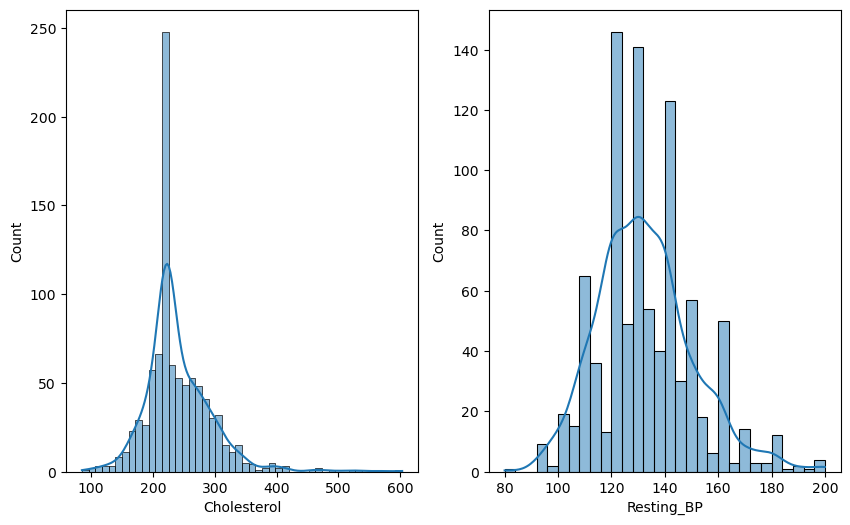

In [12]:
#generate histogram for cholesterol and resting BP
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.histplot(heart_data_clean['Cholesterol'], kde=True)
plt.xlabel('Cholesterol')

plt.subplot(1,2,2)
sns.histplot(heart_data_clean['RestingBP'], kde=True)
plt.xlabel('Resting_BP')

plt.show()

c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


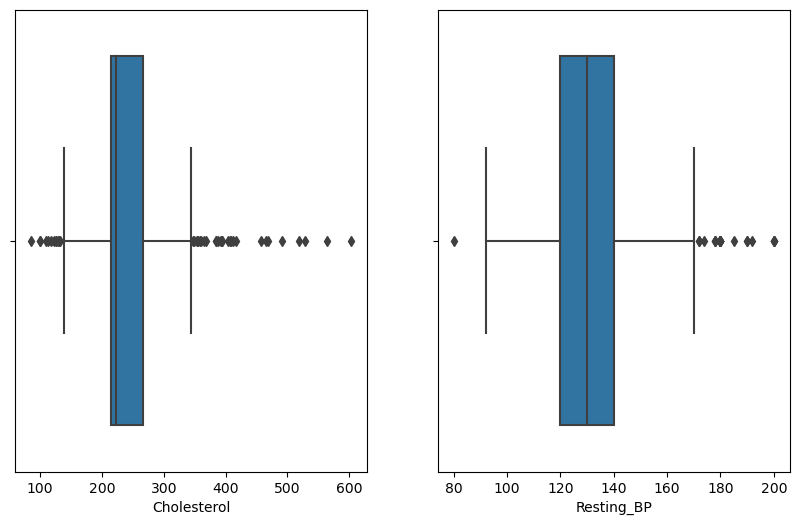

In [13]:
#generate boxplot for cholesterol and resting BP
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(heart_data_clean['Cholesterol'])
plt.xlabel('Cholesterol')

plt.subplot(1,2,2)
sns.boxplot(heart_data_clean['RestingBP'])
plt.xlabel('Resting_BP')

plt.show()

After correcting the zeros, we observe several outliers above 400 and below 150 for `Cholesterol` and outliers above 170 for `RestingBP`. We will proceed to remove some outliers using modified z score < 3.5 that uses median instead of mean as our distributions are slightly skewed towards the left in both features.

In [14]:
# using modified z score

def get_modified_z_score(x, feature):
    median = np.median(feature)
    mad = np.median(abs(feature - median))
    modified_z_score = 0.6745*(x - median)/mad
    return modified_z_score

In [15]:
heart_data_clean['cholesterol_mod_zscore'] = heart_data_clean.Cholesterol.apply(lambda x: get_modified_z_score(x, heart_data_clean.Cholesterol))


In [16]:
#check mod z score more than 3.5

sum(heart_data_clean['cholesterol_mod_zscore']>3.5)

27

In [17]:
#check mod z score less than -3.5
sum(heart_data_clean['cholesterol_mod_zscore']< -3.5)

1

In [18]:
heart_data_clean = heart_data_clean[heart_data_clean['cholesterol_mod_zscore'] <=3.5]
heart_data_clean = heart_data_clean[heart_data_clean['cholesterol_mod_zscore'] >=-3.5]

28 outliers are remove from `cholesterol` feature.

In [19]:
heart_data_clean['resting_mod_zscore'] = heart_data_clean.RestingBP.apply(lambda x: get_modified_z_score(x, heart_data_clean.RestingBP))


In [20]:
#check mod z score more than 3.5
sum(heart_data_clean['resting_mod_zscore']>3.5)

8

In [21]:
#check mod z score less than -3.5
sum(heart_data_clean['resting_mod_zscore']<-3.5)

0

In [22]:
heart_data_clean = heart_data_clean[heart_data_clean['resting_mod_zscore'] <=3.5]


8 outliers are removed from `Resting BP`.

In [23]:
heart_data_clean['MaxHR_mod_zscore'] = heart_data_clean.MaxHR.apply(lambda x: get_modified_z_score(x, heart_data_clean.MaxHR))

In [24]:
#check mod z score more than 3.5
sum(heart_data_clean['MaxHR_mod_zscore']>3.5)

0

In [25]:
#check mod z score less than -3.5
sum(heart_data_clean['MaxHR_mod_zscore']<-3.5)

0

There are no outliers for `MaxHR`

In [26]:
heart_data_clean['oldpeak_mod_zscore'] = heart_data_clean.Oldpeak.apply(lambda x: get_modified_z_score(x, heart_data_clean.Oldpeak))

In [27]:
#check mod z score more than 3.5
sum(heart_data_clean['oldpeak_mod_zscore']>3.5)

26

In [28]:
#check mod z score less than -3.5
sum(heart_data_clean['oldpeak_mod_zscore']<-3.5)

1

In [29]:
heart_data_clean = heart_data_clean[heart_data_clean['oldpeak_mod_zscore'] <=3.5]
heart_data_clean = heart_data_clean[heart_data_clean['oldpeak_mod_zscore'] >=-3.5]

In [30]:
heart_data_clean.shape[0]

854

27 outliers have been removed in `OldPeak`. 
A total of 64 rows have been removed.
There are 854 rows left.

## EDA visualisation: Categorical columns

We will analyse the categorical columns next and create bar charts for each of them to understand how the data is distributed

c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\newu

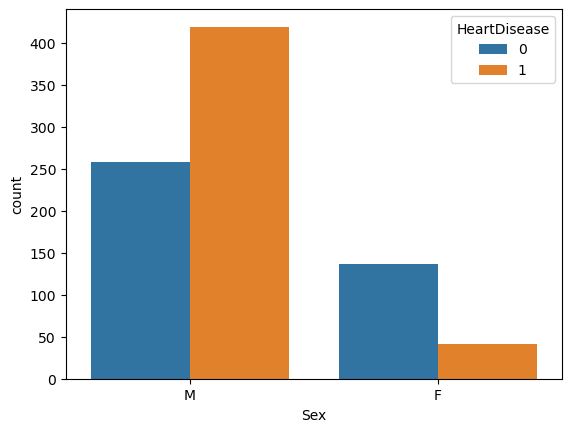

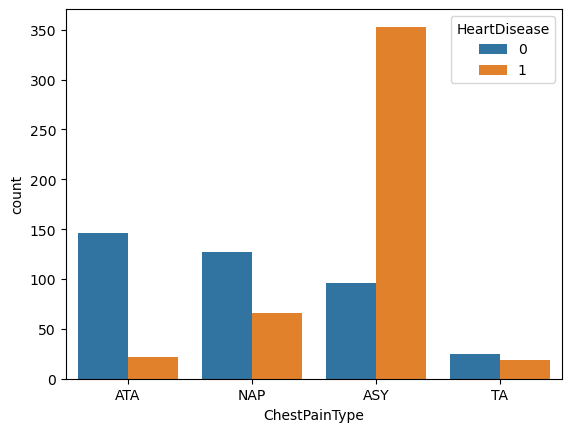

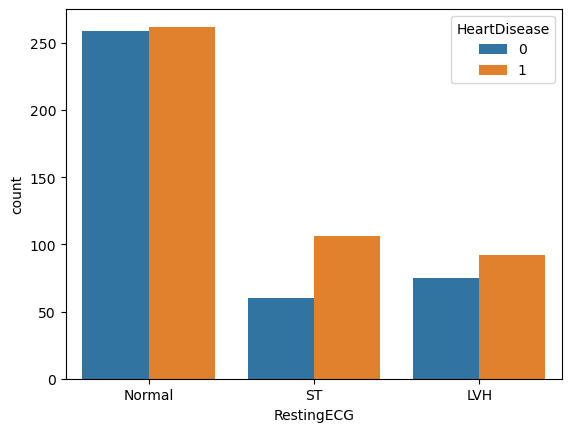

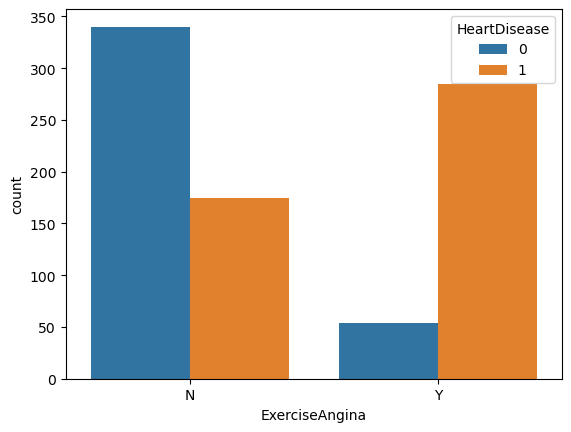

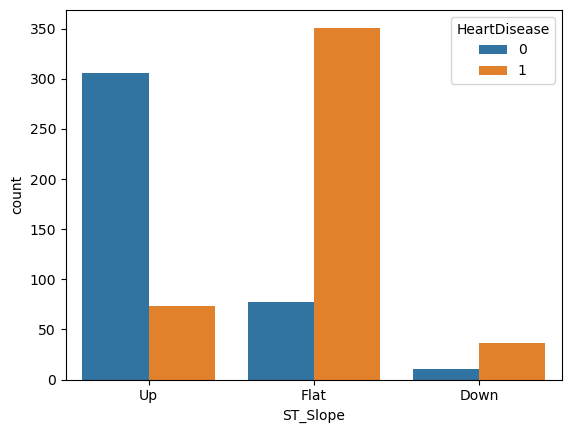

In [31]:
categories = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

#loop over each category to create bar plot
for cat in categories:
    plt.figure()
    sns.countplot(heart_data_clean[cat], hue=heart_data_clean['HeartDisease'])



- `Sex` - The data appears to contain almost 4 times more male than female patients that has heart disease
- `Chest Pain Type` - suggests that heart disease is most common in `ASY` asymptomatic chest pain, 4 times higher than the next highest type - `NAP` Non-anginal pain
- `Resting ECG` - appears to show most people have normal Resting ECG, and  heart disease with normal Resting ECG is 50/50. Within `ST` or `LVH`, heart disease has a higher possibility.
- `Exercise Angina` - Exercise induced angina is almost 30% more than non exercise induced angina in confirmed heart disease.
- `ST_Slope` - Suggests that `Flat` ST_slope has the highest number of confirmed heart disease, about 4 times more than `Up` and `Down` type.

c:\Users\newusername\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

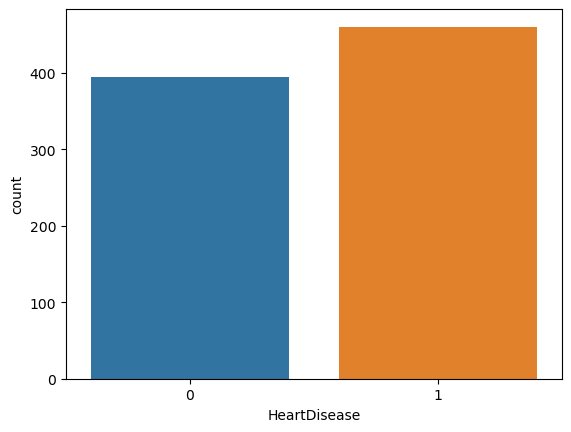

In [32]:
sns.countplot(heart_data_clean.HeartDisease)

We should also note that the number of records for `HeartDisease` is not balanced. As such we may have to deploy a stratified training/testing distribution to ensure a balanced distribution in our training data.

# Data Preprocessing - Convert categorical columns to numerics

In [33]:
#drop first dummy column to avoid dummy variable trap
dummies= pd.get_dummies(heart_data_clean[categories], drop_first=True)
dummies.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,1,1,0,0,1,0,0,0,1
1,0,0,1,0,1,0,0,1,0
2,1,1,0,0,0,1,0,0,1
3,0,0,0,0,1,0,1,1,0
4,1,0,1,0,1,0,0,0,1


In [34]:
#join back to main df
heart_data_clean = pd.concat([heart_data_clean, dummies], axis=1)

#drop categories columns
heart_data_clean = heart_data_clean.drop(categories, axis='columns')

#drop zscore columns
heart_data_clean = heart_data_clean.drop(['cholesterol_mod_zscore', 'resting_mod_zscore', 'oldpeak_mod_zscore', 'MaxHR_mod_zscore'], axis='columns')

heart_data_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289.0,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180.0,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283.0,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214.0,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195.0,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [35]:
heart_data_clean.tail()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
912,57,140,241.0,0,123,0.2,1,0,0,0,0,1,0,1,1,0
913,45,110,264.0,0,132,1.2,1,1,0,0,1,1,0,0,1,0
915,57,130,131.0,0,115,1.2,1,1,0,0,0,1,0,1,1,0
916,57,130,236.0,0,174,0.0,1,0,1,0,0,0,0,0,1,0
917,38,138,175.0,0,173,0.0,0,1,0,1,0,1,0,0,0,1


In [36]:
heart_data_clean.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [37]:
heart_data_clean.shape

(854, 16)

# Data Preprocessing - Min Max Scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(heart_data_clean[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])

#assign index param to match original df to avoid new index assigned
scaled_features = pd.DataFrame(scaled_features, columns=['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], index=heart_data_clean.index)

scaled_features 

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,0.244898,0.60,0.759036,0.788732,0.40
1,0.428571,0.80,0.321285,0.676056,0.60
2,0.183673,0.50,0.734940,0.267606,0.40
3,0.408163,0.58,0.457831,0.338028,0.70
4,0.530612,0.70,0.381526,0.436620,0.40
...,...,...,...,...,...
912,0.591837,0.60,0.566265,0.443662,0.44
913,0.346939,0.30,0.658635,0.507042,0.64
915,0.591837,0.50,0.124498,0.387324,0.64
916,0.591837,0.50,0.546185,0.802817,0.40


In [39]:
heart_data_scaled = heart_data_clean.copy()

heart_data_scaled[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']] = scaled_features

heart_data_scaled.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,0.244898,0.60,0.759036,0,0.788732,0.4,0,1,1,0,0,1,0,0,0,1
1,0.428571,0.80,0.321285,0,0.676056,0.6,1,0,0,1,0,1,0,0,1,0
2,0.183673,0.50,0.734940,0,0.267606,0.4,0,1,1,0,0,0,1,0,0,1
3,0.408163,0.58,0.457831,0,0.338028,0.7,1,0,0,0,0,1,0,1,1,0
4,0.530612,0.70,0.381526,0,0.436620,0.4,0,1,0,1,0,1,0,0,0,1


In [40]:
heart_data_scaled.shape

(854, 16)

# Building Models - GridSearchCV to build and test different models
Using GridSearchCV and 10 Kfold train/test validation method, we will cross validate a few models to find the best model, parameters and prediction accuracy score.

In [41]:
X = heart_data_scaled.drop(['HeartDisease'], axis='columns')
y = heart_data_scaled['HeartDisease']

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#create model and parameters dictionary

model_params = {
    'k_neighbors' : {
        'model' : KNeighborsClassifier(n_neighbors=5),
        'params' : {
            'n_neighbors' : np.arange(20)
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : np.arange(20)
        }
    },
    'svm' : {
        'model' : SVC(),
        'params' : {
            'C': np.arange(20),
            'kernel' : ['rbf', 'linear']
        }
    },
    'logistic_reg' :{
        'model' : LogisticRegression(),
        'params' : {
            'C': np.arange(20)
        }
    }
}


In [43]:
# Run GridSearchCV with 10 Kfold

results = []

for model_name, model_params in model_params.items():
    clf = GridSearchCV(model_params['model'], model_params['params'], cv=10, return_train_score=False)
    clf.fit(X, y)
    results.append({
        'model' : model_name,
        'best_score': clf.best_score_,
        'best_param': clf.best_params_
    })

pd.DataFrame(results)

c:\Users\newusername\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\newusername\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

c:\Users\newusername\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\newusername\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

,model,best_score,best_param
0,k_neighbors,0.846430,{'n_neighbors': 14}
1,random_forest,0.842845,{'n_estimators': 13}
2,svm,0.848824,"{'C': 5, 'kernel': 'linear'}"
3,logistic_reg,0.842969,{'C': 1}


**SVM** model seems to perform the best with 84.8% accuracy and best parameter of `C=5` and `linear kernel`.

# Using Principal Component Analysis
- As the above loop may take up a lot of computation cost, we will try to reduce dimensionality to reduce computation time

In [44]:
from sklearn.decomposition import PCA

#retain 90% of original info
pca = PCA(0.9)

X_pca = pca.fit_transform(X)

X_pca.shape

(854, 8)

Using PCA method for features extraction, we summarised the number of features from 15 to 8. 
Let's run these features with the SVM model identified earlier.

In [52]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(SVC(C=5, kernel='linear'), X_pca, y, cv=10)

cv


array([0.90697674, 0.94186047, 0.77906977, 0.87209302, 0.85882353,
       0.81176471, 0.89411765, 0.84705882, 0.74117647, 0.72941176])

In [53]:
#average score
np.mean(cv)

0.8382352941176471

83.8% accuracy is a slight drop from 84.8% in our earlier model. We can run a for loop to test various accuracy of different PCA component values to see if there is an improvement in scores.

Text(0.5, 1.0, 'Pca accuracy with SVM model')

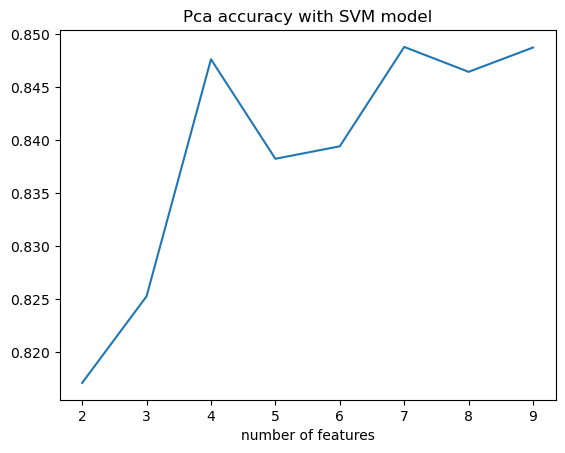

In [54]:
#for loop to plot various accuracy difference with different PCA component values

pca_range = [2, 3, 4, 5, 6, 7, 8, 9]

pca_accuracy_svm = []

#using SVM model
for i in pca_range:

    pca = PCA(n_components=i)

    X_pca = pca.fit_transform(X)

    cv = cross_val_score(SVC(C=5, kernel='linear', random_state=42), X_pca, y, cv=10)

    pca_accuracy_svm.append(np.mean(cv))


plt.plot(pca_range, pca_accuracy_svm)
plt.xlabel('number of features')
plt.title('Pca accuracy with SVM model')

In [55]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
cv = cross_val_score(SVC(C=5, kernel='linear', random_state=42), X_pca, y, cv=10)
np.mean(cv)

0.848796169630643

For SVM model, 7 features give the highest prediction accuracy of about 84.8%, maintaining the same accuracy as GridSearchCV, with lesser computation cost.

# Using Train Test Split to train and test dataset

Text(0.5, 0, 'test_size')

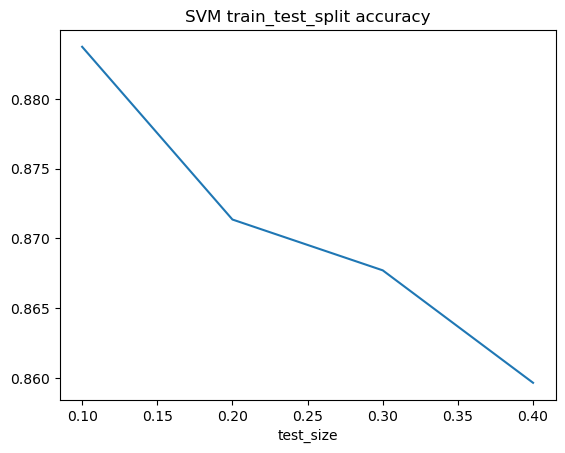

In [56]:
from sklearn.model_selection import train_test_split

#vary a few test size to check accuracy rate
test_size = [0.1, 0.2, 0.3, 0.4]
tts_svm_score = []

for t in test_size:
    #stratify because there is an imbalanced number of confirmed heart disease patient versus non-heart disease
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, stratify=y, random_state=42)

    #SVM model
    svm = SVC(C=5, kernel='linear')

    svm.fit(X_train, y_train)

    tts_svm_score.append(svm.score(X_test, y_test))

plt.plot(test_size, tts_svm_score)
plt.title('SVM train_test_split accuracy')
plt.xlabel('test_size')


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)


svm = SVC(C=5, kernel='linear')

svm.fit(X_train, y_train)

svm.score(X_test, y_test)

0.8837209302325582

We have jump to 88.3% score with 90% training data and 10% test data using the `train_test_split` method, seemingly improves the performance of SVC model.

# Using PCA on train_test_split

Text(0.5, 1.0, 'pca accuracy with SVM & train_test_split')

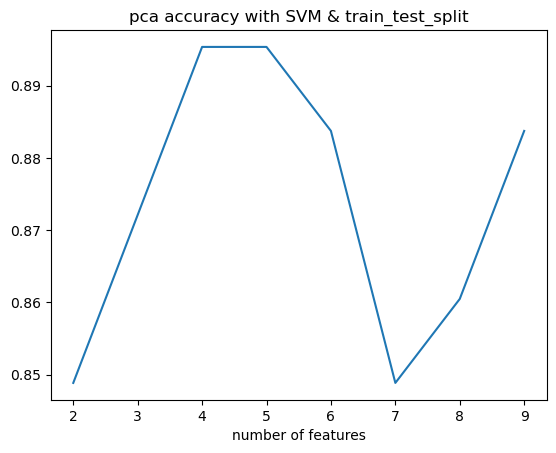

In [58]:
pca_range = [2, 3, 4, 5, 6, 7, 8, 9]

pca_accuracy_train_test_split = []

for i in pca_range:

    pca = PCA(n_components=i)

    X_pca = pca.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

    svm = SVC(C=5, kernel='linear')

    svm.fit(X_train, y_train)

    pca_accuracy_train_test_split.append(svm.score(X_test, y_test))

plt.plot(pca_range, pca_accuracy_train_test_split)
plt.xlabel('number of features')
plt.title('pca accuracy with SVM & train_test_split')

In [61]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)
svm = SVC(C=5, kernel='linear')
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.8953488372093024

With Principal Component Analysis, 4 or 5 features both performed best with SVM model (using `train_test_split` 90% training and 10% test data) surprisingly improved the results from 88.3% to close to 89.5%

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.tree import DecisionTreeRegressor  # Replace with your specific model

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Use cross_val_score to perform cross-validation
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    
    # Calculate mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


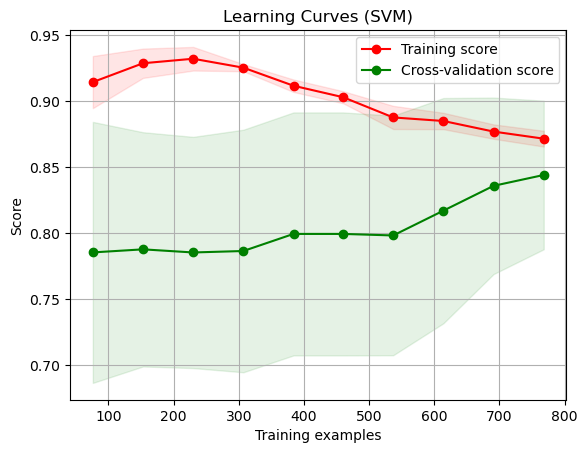

In [86]:
estimator = SVC(C=5, kernel='linear')
title = "Learning Curves (SVM)"
cv = 10  
plot_learning_curve(estimator, title, X, y, cv=cv)

plt.show()


# Conclusion
- We have maintained 93% (854 out of 918 rows) of our data after removing outliers using modified Z-score and imputating incorrect values.
- **Support Vector Machine (SVM)** performed best with accuracy score of 84.3% when cross validating with 10 Stratified Kfolds.
- Using `train_test_split` with 90% training and 10% test split, **SVM's accuracy score increase to 88.3%**
- Through Principal Component Analysis, **SVM score improved to 89.5%** with an added benefit of reducing computation cost by summarising features to 5 components.
- Learning Curves also show training score and validation score converging, suggesting that we have balanced model.